<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Abschnitt_6_Transfer_Learning/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We´ve seen the power of transfer learning feature extraction and fine tuning, now it´s time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (laveraging the power of deep learning).

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
!nvidia-smi

Sun Aug  1 11:22:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

in previous notebooks, we´ve created a series of helper functions to different taskts, let´s download them. 

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-01 11:22:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-01 11:22:45 (69.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Let´s download the training data.

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-08-01 11:22:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 142.250.141.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   214MB/s    in 6.8s    

2021-08-01 11:22:54 (228 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/foie_gras'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fish_and_chips'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pork_chop'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10

In [6]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False) #don´t shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we´re going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless Functional EfficientNetB0 backboned-model
* Compile our model
* Feature extract for 5 full passes 

In [7]:
#Create checkpoint callback
checkpoint_path = "101_classes_10_precent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
#Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

#Setup
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) #put the base model in inference mode so weights which neet to stay frozen, stays frozen
x = layers.GlobalAveragePooling2D(name="global_average_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [10]:
#Get a summary of the created model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pool_layer (G (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
#compile
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [12]:
#Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 123s 371ms/step - loss: 3.4603 - accuracy: 0.2486 - val_loss: 2.7446 - val_accuracy: 0.3655
Epoch 2/5
237/237 [==============================] - 74s 309ms/step - loss: 2.3506 - accuracy: 0.4537 - val_loss: 2.3290 - val_accuracy: 0.4327
Epoch 3/5
237/237 [==============================] - 67s 280ms/step - loss: 1.9680 - accuracy: 0.5295 - val_loss: 2.1823 - val_accuracy: 0.4476
Epoch 4/5
237/237 [==============================] - 62s 258ms/step - loss: 1.7591 - accuracy: 0.5757 - val_loss: 2.1011 - val_accuracy: 0.4605
Epoch 5/5
237/237 [==============================] - 58s 242ms/step - loss: 1.5896 - accuracy: 0.6123 - val_loss: 2.0177 - val_accuracy: 0.4754


In [13]:
#Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 89s 112ms/step - loss: 1.7084 - accuracy: 0.5562


[1.7084013223648071, 0.5561584234237671]

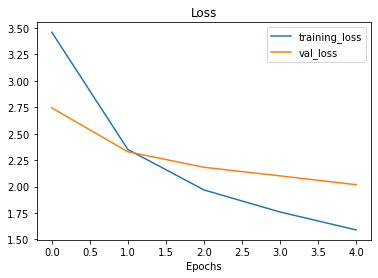

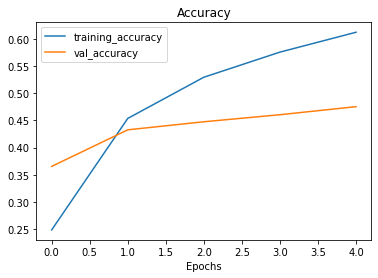

In [14]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [15]:
#Unfreeze all of the layers in the base model
base_model.trainable = True

#Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
#Recomile model with lower learning rate (best practice to lower the learning rate)
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [17]:
#what layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pool_layer True
output_layer True


In [18]:
#Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [19]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 #model has already done 5 epochs (feature extraction), this is the total number of epochs we´re after (5 + 5 = 10)

#Fine-tune our model
history_all_classes_10_perecent_fine_tune = model.fit(train_data_all_10_percent,
                                                      epochs=fine_tune_epochs,
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15 * len(test_data)),
                                                      initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 68s 260ms/step - loss: 1.3562 - accuracy: 0.6507 - val_loss: 1.9563 - val_accuracy: 0.4958
Epoch 6/10
237/237 [==============================] - 57s 238ms/step - loss: 1.2481 - accuracy: 0.6734 - val_loss: 1.9609 - val_accuracy: 0.4966
Epoch 7/10
237/237 [==============================] - 54s 225ms/step - loss: 1.1454 - accuracy: 0.6936 - val_loss: 1.9543 - val_accuracy: 0.4942
Epoch 8/10
237/237 [==============================] - 54s 226ms/step - loss: 1.0891 - accuracy: 0.7141 - val_loss: 1.9291 - val_accuracy: 0.5064
Epoch 9/10
237/237 [==============================] - 52s 216ms/step - loss: 1.0312 - accuracy: 0.7245 - val_loss: 1.9217 - val_accuracy: 0.5103
Epoch 10/10
237/237 [==============================] - 51s 213ms/step - loss: 0.9678 - accuracy: 0.7447 - val_loss: 1.9270 - val_accuracy: 0.5050


In [20]:
#Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 89s 113ms/step - loss: 1.6095 - accuracy: 0.5768


[1.6094852685928345, 0.5767524838447571]

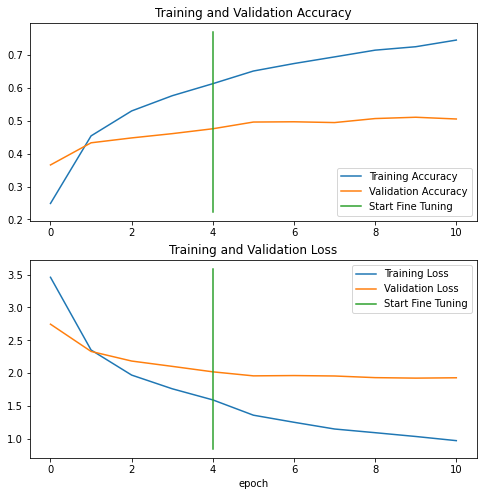

In [21]:
# Compare the histories of feature extraction with fine tuning model
compare_historys(history_all_classes_10_percent,
                 history_all_classes_10_perecent_fine_tune,
                 initial_epochs = 5)

## Saving and loading our model

To use our model in an external application, we´ll need to save it and export it somewhere else

In [22]:
# Save our fine-tuned model
model.save("drive/MyDrive/tensorflow_udemy/101_food_classes_10_percent_saved_big_dog_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_udemy/101_food_classes_10_percent_saved_big_dog_model/assets


In [23]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_udemy/101_food_classes_10_percent_saved_big_dog_model")

In [24]:
#Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 91s 113ms/step - loss: 1.6095 - accuracy: 0.5768


[1.6094852685928345, 0.5767524838447571]

In [25]:
#The results from above should be very similar to the loaded_model results
all_classes_10_percent_fine_tune_results

[1.6094852685928345, 0.5767524838447571]

## Evaluating the performance of the big dog model across all different classes

Let´s make some predictions, visualize them and then later find our which predictions were the most wrong.

In [26]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-08-01 11:45:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   105MB/s    in 0.4s    

2021-08-01 11:45:31 (105 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
#Unzip the data
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [28]:
#Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [29]:
#Evaluate loaded model (the one we just downloaded)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 93s 116ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with our trained model

In [30]:
# Make predictions with our model
preds_probs = model.predict(test_data, verbose=1) #set verbosity to see how longis left

790/790 [==============================] - 64s 80ms/step


In [31]:
len(test_data)

790

In [32]:
#How many predictions are there?
len(preds_probs)

25250

In [33]:
#What´s the shape of our predictions?
preds_probs.shape

(25250, 101)

In [34]:
#Let´s see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542004e-02, 3.5742048e-06, 4.1376974e-02, ..., 1.4138707e-09,
        8.3530831e-05, 3.0897511e-03],
       [9.6401680e-01, 1.3753246e-09, 8.4780657e-04, ..., 5.4286997e-05,
        7.8362204e-12, 9.8466024e-10],
       [9.5925879e-01, 3.2533586e-05, 1.4866921e-03, ..., 7.1891071e-07,
        5.4397117e-07, 4.0275969e-05],
       ...,
       [4.7313261e-01, 1.2931220e-07, 1.4805585e-03, ..., 5.9750013e-04,
        6.6969093e-05, 2.3469209e-05],
       [4.4571821e-02, 4.7265530e-07, 1.2258515e-01, ..., 6.3498514e-06,
        7.5318521e-06, 3.6778734e-03],
       [7.2438997e-01, 1.9249742e-09, 5.2310865e-05, ..., 1.2291356e-03,
        1.5792692e-09, 9.6395699e-05]], dtype=float32)

In [35]:
# What does the first prediction probability looks like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.95420040e-02, 3.57420481e-06, 4.13769744e-02, 1.06605957e-09,
        8.16144308e-09, 8.66396554e-09, 8.09270432e-07, 8.56525787e-07,
        1.98590351e-05, 8.09776793e-07, 3.17278026e-09, 9.86737405e-07,
        2.85321876e-04, 7.80491949e-10, 7.42302276e-04, 3.89165252e-05,
        6.47403658e-06, 2.49773507e-06, 3.78911318e-05, 2.06783668e-07,
        1.55384660e-05, 8.15070223e-07, 2.62305161e-06, 2.00107237e-07,
        8.38273706e-07, 5.42161388e-06, 3.73908892e-06, 1.31505820e-08,
        2.77614570e-03, 2.80519434e-05, 6.85626778e-10, 2.55748546e-05,
        1.66889280e-04, 7.64068475e-10, 4.04528779e-04, 1.31506335e-08,
        1.79573601e-06, 1.44482021e-06, 2.30628569e-02, 8.24668518e-07,
        8.53658491e-07, 1.71386603e-06, 7.05251614e-06, 1.84022007e-08,
        2.85533758e-07, 7.94834523e-06, 2.06815321e-06, 1.85251167e-07,
        3.36197701e-08, 3.15225829e-04, 1.04109231e-05, 8.54482778e-07,
        8.47418606e-01, 1.05554454e-05, 4.40946224e-07, 3.740432

Our model outputs a prediction probability array (with N number of variables, wehre N is the number of classes) for each sample passes to the predict method.

In [36]:
# We get on prediction probability per class (101 probabiloties in our case)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95420040e-02 3.57420481e-06 4.13769744e-02 1.06605957e-09
 8.16144308e-09 8.66396554e-09 8.09270432e-07 8.56525787e-07
 1.98590351e-05 8.09776793e-07 3.17278026e-09 9.86737405e-07
 2.85321876e-04 7.80491949e-10 7.42302276e-04 3.89165252e-05
 6.47403658e-06 2.49773507e-06 3.78911318e-05 2.06783668e-07
 1.55384660e-05 8.15070223e-07 2.62305161e-06 2.00107237e-07
 8.38273706e-07 5.42161388e-06 3.73908892e-06 1.31505820e-08
 2.77614570e-03 2.80519434e-05 6.85626778e-10 2.55748546e-05
 1.66889280e-04 7.64068475e-10 4.04528779e-04 1.31506335e-08
 1.79573601e-06 1.44482021e-06 2.30628569e-02 8.24668518e-07
 8.53658491e-07 1.71386603e-06 7.05251614e-06 1.84022007e-08
 2.85533758e-07 7.94834523e-06 2.06815321e-06 1.85251167e-07
 3.36197701e-08 3.15225829e-04 1.04109231e-05 8.54482778e-07
 8.47418606e-01 1.05554454e-05 4.40946224e-07 3.74043229e-05
 3.53062278e-05 3.24891298e-05 6.73148679e-

In [90]:
#Get the pred classes for each label
pred_classes = preds_probs.argmax(axis=1)

#How do they look?
print(pred_classes[:10])

#How many pred classes do we have?
len(pred_classes)

[52  0  0 80 79 61 29  0 85  0]


25250

In [38]:
#To get our test lables we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #currently test labels look like: [0,0,0,1,.....0,0,0,0...] - we want the index label where the 1 occurs
y_labels[:10] #look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [39]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model´s predictions

One way to check that our model´s predictions array is in the same order as out test labels array is to find the accuracy score.

In [40]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [41]:
#Let´s try scikit-learn´s accuracy function and see what it comes up with 
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)

sklearn_accuracy

0.6077623762376237

In [42]:
#Does this metric come close to our model´s evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let´s get visual: making a confusion matrix

In [43]:
from helper_functions import make_confusion_matrix

In [44]:
#get a list of class namens
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [45]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#small changes to our function to plot the x labels vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changes (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

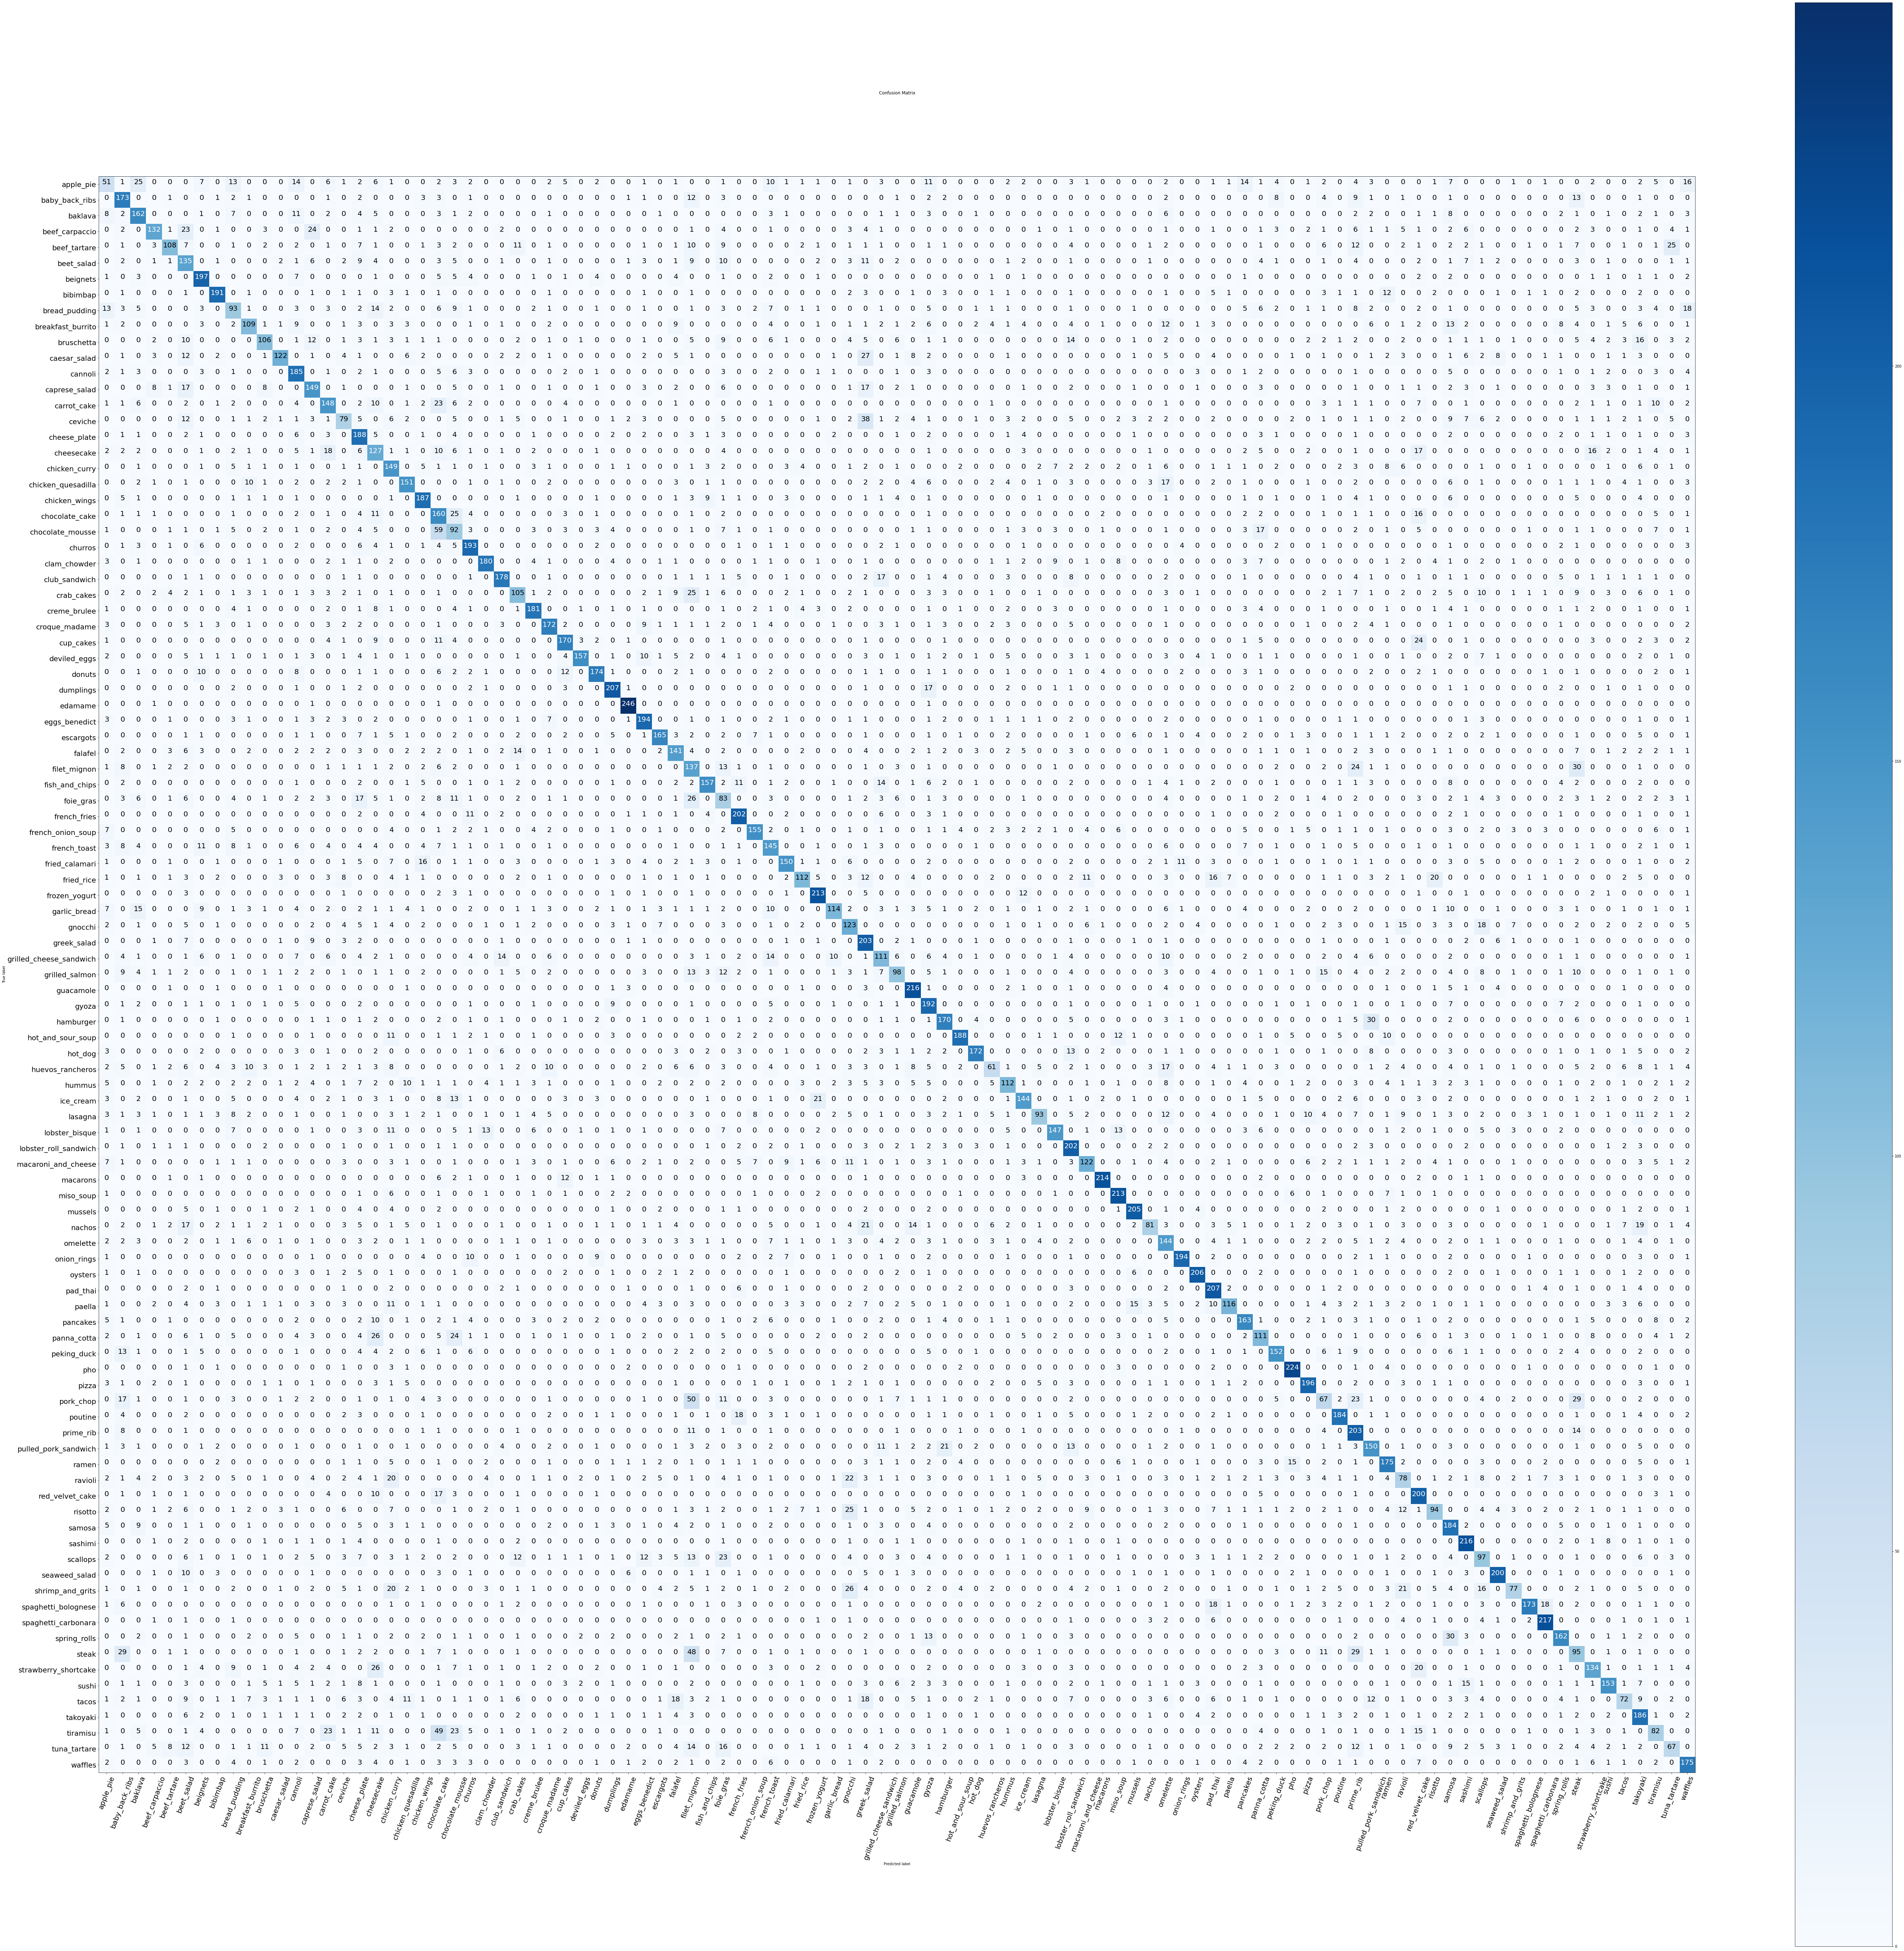

In [46]:
make_confusion_matrix(y_labels, pred_classes,class_names, figsize=(100,100), text_size=20)

## Time for a classification report

Scikit-learn has a helpful function for acuqiring many different classification metrics per class (e.g. precision, racall and F1-score).

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of our model´s predictions but with so many classes, they´re quite hard to understand.

In [48]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

In [49]:
classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [50]:
#Create empty dictionary
class_f1_scores = {}
#Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break
  else:
    #Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [51]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [52]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

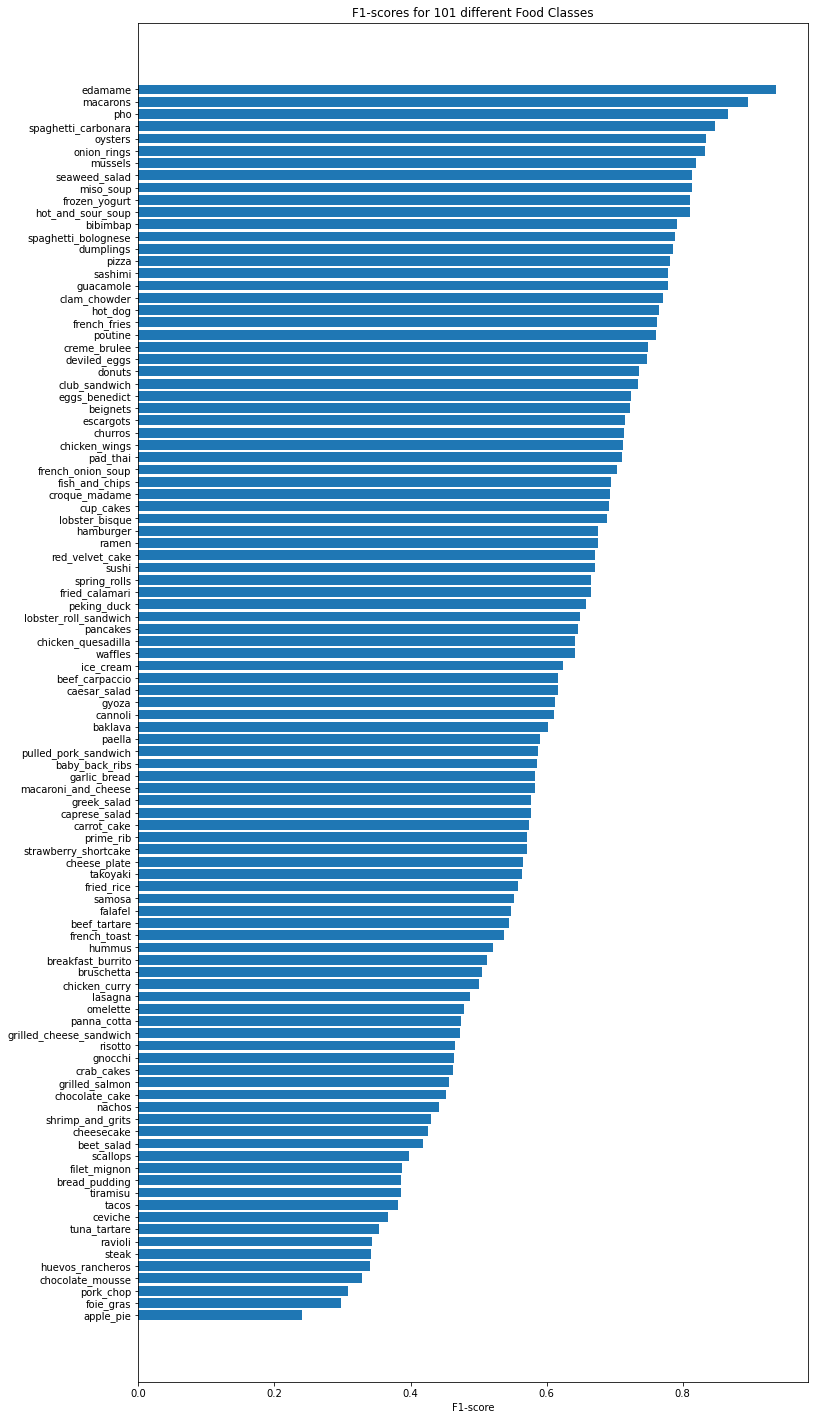

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) #get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different Food Classes")
ax.invert_yaxis() # reverse the order of our plot

## Visualizing predictions on costum images

To visualize our model´s predictions on our own images, we´ll need a function to load an preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [54]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Read in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels=3)

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """

  #Read in the image
  img = tf.io.read_file(filename)

  #Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  #Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  #Scale Yes/No
  if scale:
    #rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img #don´t need to rescale images for EfficientNet models in TensorFlow

Now we´ve got a function to load and prepare target images, let´s now write sime code to visualize images, their target label and our model´s predictions.

Specifically, we´ll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model´s predictions probability and truth label

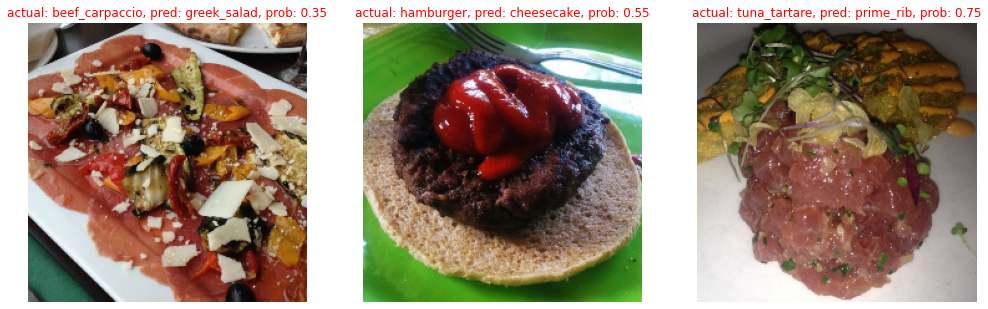

In [86]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions
To find out where our model is most wrong, let´s write some code to find out the following:

1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground thruth labels, predicted classes (from our model), max prediction probabilities, prediction class names and ground thruth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground thruth label doesn´t match the predictions).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top)
5. Visualize the images with the highes predictions probablities but have the wrong predictions.

In [87]:
# Get all the image file paths in the test dataset 
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [91]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  ...      y_pred_classname
0  b'/content/101_food_classes_10_percent/test/ap...  ...                 gyoza
1  b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
2  b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
3  b'/content/101_food_classes_10_percent/test/ap...  ...  pulled_pork_sandwich
4  b'/content/101_food_classes_10_percent/test/ap...  ...             prime_rib

[5 rows x 6 columns]

In [92]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...         False
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [93]:
# 4. Sort our DataFrame to have most wrong predictions at the top 
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False
24540  b'/content/101_food_classes_10_percent/test/ti...  ...         False
2511   b'/content/101_food_classes_10_percent/test/br...  ...         False
5574   b'/content/101_food_classes_10_percent/test/ch...  ...         False
17855  b'/content/101_food_classes_10_percent/test/pa...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
11642  b'/content/101_food_classes_10_percent/test/ga...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
1155   b'/content/101_food_classes_10_percent/test/be...  ...         False
10854  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23904  b'/content/101_food_classes_10_percent/test/su...  ...         False
7316   b'/content/101_food_classes_10_percent/test/cu...  ...         False
13144  b'/content/101_food_classes_10_percent/test/gy...  ...         False
10880  b'/content/101_food_classes_10_percent/test/fr...  ...         False

[20 rows x 7 columns]

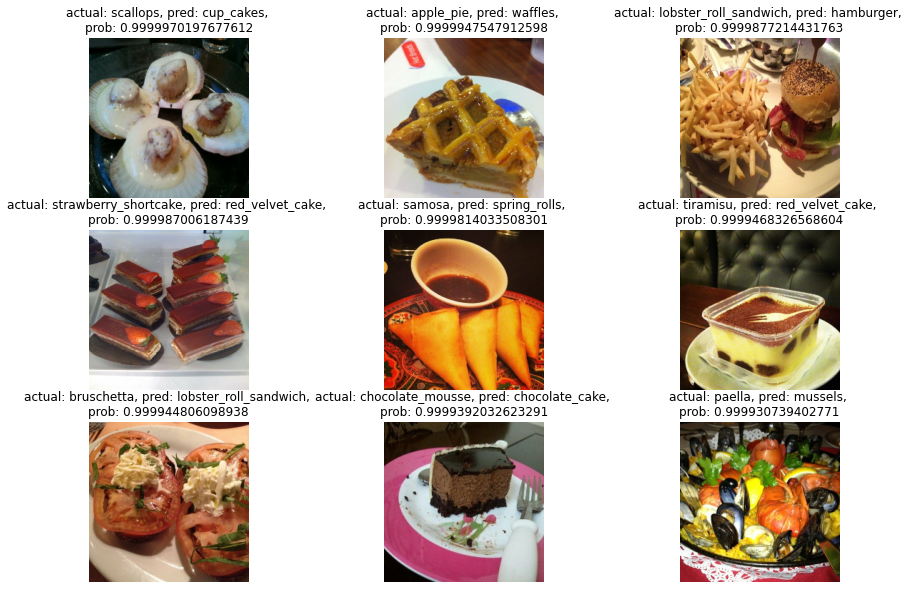

In [100]:
# 5. Visualize the test data samples which have the wrong predictions but highest predictions probabilities
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row #only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False)

## Test out the big dog model on our own costum images


In [102]:
# Get costum images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2021-08-01 13:08:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.06s   

2021-08-01 13:08:12 (218 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [103]:
# Get the costum food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg']

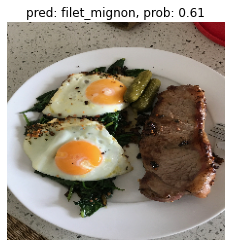

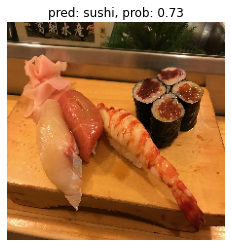

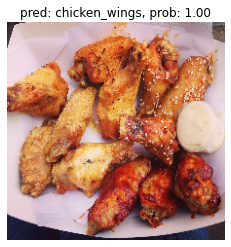

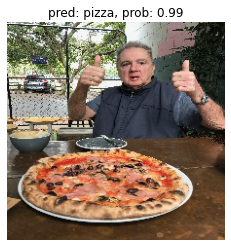

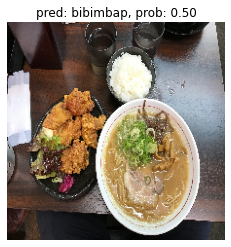

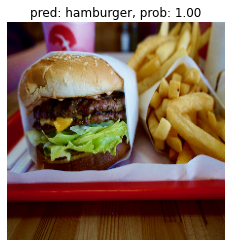

In [105]:
#Make predictions and plot costum food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  #Plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)